In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [2]:
prev_timesteps = 6
prediction_steps = 2
batch_size = 50

train = MoviaBusDataset('../data/train', interpolation=True, \
                        prev_timesteps=prev_timesteps, \
                        max_future_time_steps=prediction_steps, \
                        sequence_target=True              )
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, max_future_time_steps=prediction_steps)

train.normalize()
test.normalize(train.mean, train.std)



In [3]:
train[0]['target'].size()

torch.Size([2, 194])

In [109]:
train_DL = DataLoader(train, batch_size=batch_size, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [110]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[0]

class Encoder(nn.Module):
    def __init__(self, num_input, num_encoding):
        super(Encoder, self).__init__()
        
        self.lstm = nn.LSTM(num_input, num_encoding, batch_first=True)
        
        #self.num_layers = num_layers
        
    # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        n_batch = x.size()[0]
        hidden = (torch.randn(1, n_batch, num_roads),
                  torch.randn(1, n_batch, num_roads))

        
        #x : [batch_size, timesteps, wayids]   
        out, hidden = self.lstm(x, hidden)
        
        return out
    
class Decoder(nn.Module):
    def __init__(self, num_input, num_encoding):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(num_input, num_encoding, batch_first=True)
        
        #self.num_layers = num_layers
        
    # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x, hidden, max_timesteps):
        n_batch = x.size()[0]
        hidden = (torch.randn(1, n_batch, num_roads),
                  torch.randn(1, n_batch, num_roads))

        
        #x : [batch_size, timesteps, wayids]   
        out, hidden = self.lstm(x, hidden)
        
        return out


net = RNN(2)

optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
criterion = nn.L1Loss()

In [111]:
net.train()
for epoch in range(100):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'][:,:,:-1]).squeeze()
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
    
    
    net.eval()
    for i, batch in enumerate(test_DL):

        output = net(batch['data'][:,:,:-1]).squeeze()
        target = batch['target']

        loss_test = criterion(output,target)
    print("epoch = %2i  loss_train = %0.3f  loss_test = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), loss_test, output.std().item()))

epoch =  0  loss_train = 0.757  loss_test = 0.773  output_std = 0.055
epoch =  1  loss_train = 0.754  loss_test = 0.772  output_std = 0.055
epoch =  2  loss_train = 0.751  loss_test = 0.770  output_std = 0.057
epoch =  3  loss_train = 0.748  loss_test = 0.768  output_std = 0.060
epoch =  4  loss_train = 0.745  loss_test = 0.766  output_std = 0.065
epoch =  5  loss_train = 0.741  loss_test = 0.764  output_std = 0.072
epoch =  6  loss_train = 0.736  loss_test = 0.761  output_std = 0.083
epoch =  7  loss_train = 0.730  loss_test = 0.758  output_std = 0.098
epoch =  8  loss_train = 0.723  loss_test = 0.754  output_std = 0.118
epoch =  9  loss_train = 0.717  loss_test = 0.750  output_std = 0.141
epoch = 10  loss_train = 0.711  loss_test = 0.747  output_std = 0.165
epoch = 11  loss_train = 0.707  loss_test = 0.744  output_std = 0.183
epoch = 12  loss_train = 0.703  loss_test = 0.743  output_std = 0.196
epoch = 13  loss_train = 0.700  loss_test = 0.742  output_std = 0.203
epoch = 14  loss_tra

In [112]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'][:,:,:-1]).squeeze()
    target = batch['target']
        
    output = output*torch.tensor(train.std) + torch.tensor(train.mean)
    target = target*torch.tensor(train.std) + torch.tensor(train.mean)
    
    loss = criterion(output,target)
    print(loss.item())

1.6639816761016846


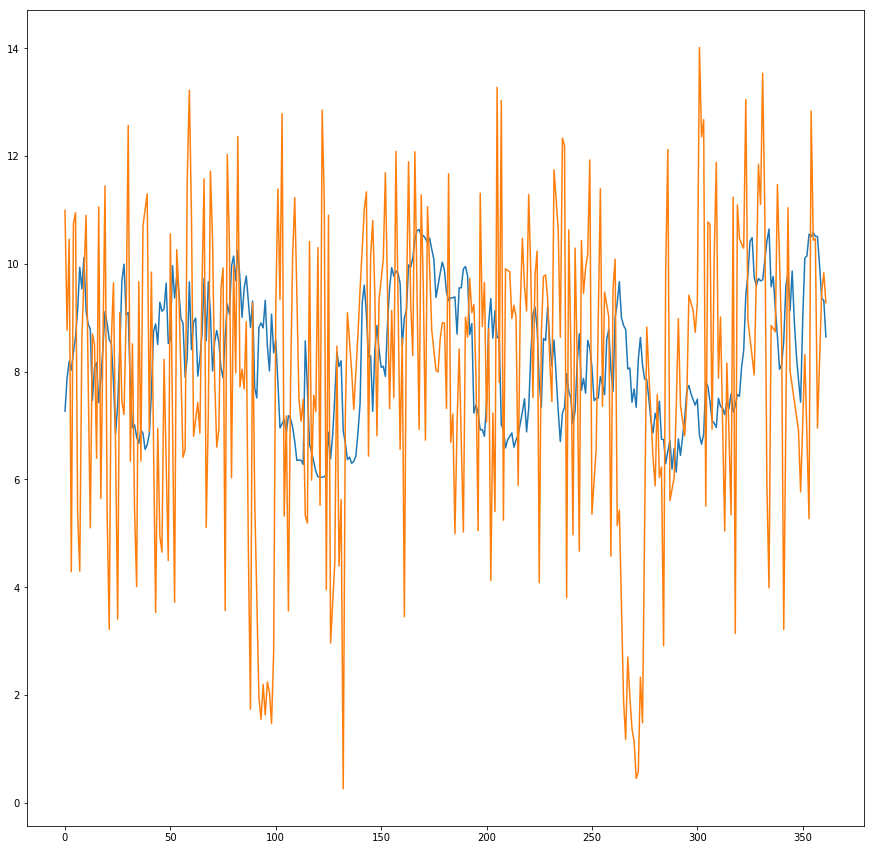

In [107]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.plot(output[:,1].detach().numpy())
plt.plot(target[:,1].detach().numpy())